## **1. 라이브러리 설치**

In [ ]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 102.4 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
from google.colab import files
import os
import zipfile
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import yaml
import shutil
from tqdm import tqdm
from glob import glob
import random
import numpy as np
import torch
from ultralytics import YOLO
from IPython.display import Image, display
import glob
import koreanize_matplotlib
from google.colab import files
from glob import glob
from PIL import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2. 시드 고정**

In [ ]:
random.seed(71)
np.random.seed(71)
torch.manual_seed(71)
torch.cuda.manual_seed(71)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **3. 데이터 경로 설정**

In [ ]:
# 데이터 경로
data_path = '/content/drive/MyDrive/codeit_level1_project/additional_data'
test_dir = '/content/drive/MyDrive/codeit_level1_project/data/test_images'

## **4. 하이퍼파라미터 조정**

- 본 실험에서는 최종 훈련 모델은 YOLOv11x로 설정하되,
튜닝 시간 단축과 자원 절약을 위해 YOLOv11n 모델로 하이퍼파라미터 튜닝을 진행하였다.
- 튜닝에는 Ultralytics에서 제공하는 model.tune() 기능을 사용하였으며, 총 5회 반복 탐색(iterations=5)을 수행하였다.

| 분류             | 파라미터                                                                         | 이유                             |
| -------------- | ---------------------------------------------------------------------------- | ------------------------------ |
| 학습률 최적화     | `lr0`, `lrf`, `momentum`, `weight_decay`, `warmup_epochs`, `warmup_momentum` | 학습 속도/안정성 최적화                  |
| 손실 함수 가중치   | `box`, `cls`                                                                 | 위치 정확도와 클래스 예측 균형 맞추기          |
| 기본 증강       | `hsv_h`, `hsv_s`, `hsv_v`, `fliplr`, `mosaic`                                | 색상/방향 변화를 통한 일반화 강화            |


In [ ]:
model = YOLO("yolo11n.pt")

search_space = {
    "lr0": (1e-5, 1e-1),
    "lrf": (0.01, 1.0),
    "momentum": (0.6, 0.98),
    "weight_decay": (0.0, 0.001),
    "warmup_epochs": (0.0, 5.0),
    "warmup_momentum": (0.0, 0.95),
    "box": (0.02, 0.2),
    "cls": (0.2, 4.0),
    "hsv_h": (0.0, 0.1),
    "hsv_s": (0.0, 0.9),
    "hsv_v": (0.0, 0.9),
    "fliplr": (0.0, 1.0),
    "mosaic": (0.0, 1.0)
}

model.tune(
    data="/content/drive/MyDrive/codeit_level1_project/data/data.yaml",
    epochs=10,
    iterations=5,
    imgsz=640,
    optimizer="AdamW",
    space=search_space,
    save=True,
    project="/content/drive/MyDrive/codeit_level1_project/yolo11_0602",
    name="yolo_tuning_results",
    seed=71
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 347MB/s]

Tuner: Initialized Tuner instance with 'tune_dir=/content/drive/MyDrive/codeit_level1_project/yolo11_0602/yolo_tuning_results'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/5 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 0.2, 'cls': 0.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'fliplr': 0.5, 'mosaic': 1.0}


Saved /content/drive/MyDrive/codeit_level1_project/yolo11_0602/yolo_tuning_results/tune_scatter_plots.png
Saved /content/drive/MyDrive/codeit_level1_project/yolo11_0602/yolo_tuning_results/tune_fitness.png

Tuner: 1/5 iterations complete ✅ (433.69s)
Tuner: Results saved to /content/drive/MyDrive/codeit_level1_project/yolo11_0602/yolo_tuning_results
Tuner: Best fitness=0.94231 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.98201, 'metrics/recall(B)': 0.98365, 'metrics/mAP50(B)': 0.97714, 'metrics/mAP50-95(B)': 0.93844, 'val/box_loss': 0.00816, 'val/cls_loss': 0.26437, 'val/dfl_loss': 0.79533, 'fitness': 0.94231}
Tuner: Best fitness model is /content/drive/MyDrive/codeit_level1_project/yolo11_0602/train
Tuner: Best fitness hyperparameters are printed below.

Printing '/content/drive/MyDrive/codeit_level1_project/yolo11_0602/yolo_tuning_results/best_hyperparameters.yaml'

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup

## **5. YOLO11x 모델 훈련 및 검증**

### 5.1 모델 구성 및 학습

- 앞서 model.tune()을 활용하여 YOLOv11n 모델로 총 13개의 하이퍼파라미터를 탐색하였으며,
그 중 성능이 가장 우수한 조합을 기반으로 YOLOv11x 모델 학습을 진행하였다.

- 모델 훈련에는 Ultralytics 프레임워크의 YOLO.train() 메서드를 사용하였으며,
총 100 epoch 동안 AdamW 옵티마이저를 적용하여 훈련을 수행하였다.

In [ ]:
model = YOLO("yolo11x.pt")

In [ ]:
overrides = {
    "data": "/content/drive/MyDrive/codeit_level1_project/data/data.yaml",
    "epochs": 100,
    "imgsz": 640,
    "batch": 16,
    "optimizer": "AdamW",
    "seed": 71,
    "device": 0,
    "project": "/content/drive/MyDrive/codeit_level1_project/yolo11_0602",
    "name": "train_result",

    # 튜닝된 하이퍼파라미터
    "lr0": 0.00667,
    "lrf": 0.01114,
    "momentum": 0.71008,
    "weight_decay": 0.00035,
    "warmup_epochs": 2.84194,
    "warmup_momentum": 0.93368,
    "box": 0.2,
    "cls": 0.53341,
    "hsv_h": 0.01631,
    "hsv_s": 0.62088,
    "hsv_v": 0.26415,
    "fliplr": 0.51797,
    "mosaic": 0.85356,
}

model.train(**overrides)

New https://pypi.org/project/ultralytics/8.3.147 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=0.2, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.53341, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/codeit_level1_project/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.51797, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.01631, hsv_s=0.62088, hsv_v=0.26415, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00667, lrf=0.01114, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.71008, mosaic=0.85356, mul

train: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/train.cache... 2316 images, 0 backgrounds, 4 corrupt: 100%|██████████| 2316/2316 [00:00<?, ?it/s]

train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-001900-016551-031705-033208_0_2_0_2_90_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.9431]
train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-003351-016262-018357_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     6.8878]
train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-003544-012247-016548-029451_0_2_0_2_90_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.1211]
train: /content/drive/MyDrive/codeit_level1_project/additional_data/images/train/K-006563-012247-016551-024850_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     5.8352]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weig

val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 300.9±94.4 MB/s, size: 1740.7 KB)


val: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/val.cache... 579 images, 0 backgrounds, 2 corrupt: 100%|██████████| 579/579 [00:00<?, ?it/s]

val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016548-024850-029451_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1419      2.0318]
val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016551-021771-031705_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.3945      4.6352]


Plotting labels to /content/drive/MyDrive/codeit_level1_project/yolo11_0602/train_result/labels.jpg... 
optimizer: AdamW(lr=0.00667, momentum=0.71008) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.00035), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/codeit_level1_project/yolo11_0602/train_result
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      29.3G     0.0211      2.122      1.075         60        640: 100%|██████████| 145/145 [00:42<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.19it/s]

                   all        577       2308      0.124      0.106      0.122      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      29.7G    0.02012      1.642      1.039         49        640: 100%|██████████| 145/145 [00:37<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.33it/s]

                   all        577       2308     0.0956      0.381      0.164      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      29.9G    0.01924      1.364      1.021         52        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.44it/s]

                   all        577       2308      0.453      0.509      0.543      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      29.9G    0.01741      1.164     0.9846         78        640: 100%|██████████| 145/145 [00:38<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.18it/s]


                   all        577       2308      0.528      0.627      0.598      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      29.9G    0.01626     0.9962     0.9676         45        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.32it/s]

                   all        577       2308      0.784      0.787      0.885      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      29.9G    0.01496     0.8688     0.9431         48        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.34it/s]

                   all        577       2308      0.819      0.858      0.931      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      29.7G    0.01426     0.7999     0.9338         64        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.47it/s]

                   all        577       2308      0.765      0.867      0.909      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      29.9G    0.01441     0.7396     0.9264         36        640: 100%|██████████| 145/145 [00:38<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.50it/s]

                   all        577       2308      0.796      0.941      0.922      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      29.9G    0.01383     0.6944     0.9247         39        640: 100%|██████████| 145/145 [00:38<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308       0.76      0.879      0.898      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      29.9G    0.01343     0.6715     0.9162         64        640: 100%|██████████| 145/145 [00:38<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.773      0.854      0.886      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      29.7G    0.01285     0.6223     0.9093         43        640: 100%|██████████| 145/145 [00:38<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]

                   all        577       2308      0.744      0.621      0.805      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      29.9G     0.0128     0.5755     0.9082         54        640: 100%|██████████| 145/145 [00:38<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.923      0.936      0.957      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      29.9G    0.01239     0.5522     0.9015         41        640: 100%|██████████| 145/145 [00:40<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]

                   all        577       2308      0.952      0.964      0.966      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      29.9G     0.0122     0.5313     0.9025         60        640: 100%|██████████| 145/145 [00:41<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]

                   all        577       2308      0.946      0.972      0.968      0.918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      29.7G    0.01208     0.5156     0.8966         42        640: 100%|██████████| 145/145 [00:39<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]

                   all        577       2308       0.94      0.901      0.968      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      29.9G    0.01182      0.492     0.8957         55        640: 100%|██████████| 145/145 [00:38<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.42it/s]

                   all        577       2308      0.926      0.977      0.958      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      29.9G    0.01186     0.4842     0.8972         47        640: 100%|██████████| 145/145 [00:38<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]

                   all        577       2308      0.911      0.966      0.958      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      29.9G    0.01158      0.469      0.889         61        640: 100%|██████████| 145/145 [00:38<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.17it/s]

                   all        577       2308      0.972      0.973      0.978      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      29.7G    0.01153     0.4391     0.8869         49        640: 100%|██████████| 145/145 [00:44<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.41it/s]

                   all        577       2308      0.948      0.975      0.977      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      29.9G    0.01138     0.4413     0.8896         54        640: 100%|██████████| 145/145 [00:47<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        577       2308      0.976      0.974      0.976      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      29.9G    0.01146     0.4377     0.8917         66        640: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.19it/s]

                   all        577       2308      0.972      0.978      0.974      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      29.9G    0.01094     0.4219     0.8829         56        640: 100%|██████████| 145/145 [00:49<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        577       2308      0.968      0.978       0.98      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      29.7G    0.01088     0.4156     0.8856         33        640: 100%|██████████| 145/145 [00:42<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.50it/s]

                   all        577       2308       0.98      0.979      0.978      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      29.9G    0.01085     0.4086     0.8814         38        640: 100%|██████████| 145/145 [00:42<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]

                   all        577       2308      0.982      0.982      0.976      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      29.9G    0.01091     0.4028     0.8776         48        640: 100%|██████████| 145/145 [00:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.40it/s]

                   all        577       2308      0.967      0.971      0.972       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      29.9G     0.0107     0.3949     0.8769         71        640: 100%|██████████| 145/145 [00:42<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.44it/s]

                   all        577       2308      0.968      0.973      0.977      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      29.7G    0.01045     0.3831     0.8754         59        640: 100%|██████████| 145/145 [00:42<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.46it/s]

                   all        577       2308      0.967      0.971      0.976      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      29.9G    0.01058     0.3747     0.8767         37        640: 100%|██████████| 145/145 [00:42<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]

                   all        577       2308      0.983      0.984      0.978      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      29.9G    0.01026      0.372     0.8743         67        640: 100%|██████████| 145/145 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.50it/s]

                   all        577       2308      0.977       0.97      0.975      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      29.9G    0.01039     0.3578     0.8742         72        640: 100%|██████████| 145/145 [00:42<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]

                   all        577       2308      0.983      0.983      0.979      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      29.7G    0.01018     0.3558     0.8696         49        640: 100%|██████████| 145/145 [00:42<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.44it/s]

                   all        577       2308       0.96      0.979      0.974      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      29.9G    0.01011     0.3603     0.8719         67        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.49it/s]

                   all        577       2308       0.97      0.973      0.981      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      29.9G    0.01013       0.35     0.8755         46        640: 100%|██████████| 145/145 [00:47<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.40it/s]

                   all        577       2308      0.982      0.984      0.979      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      29.9G   0.009874     0.3432     0.8675         51        640: 100%|██████████| 145/145 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.42it/s]

                   all        577       2308      0.982      0.983      0.978       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      29.7G    0.00999     0.3349     0.8681         49        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.982      0.983      0.981      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      29.9G   0.009818      0.329     0.8675         54        640: 100%|██████████| 145/145 [00:47<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.36it/s]

                   all        577       2308      0.982      0.984      0.979      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      29.9G   0.009876     0.3329     0.8678         57        640: 100%|██████████| 145/145 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.40it/s]

                   all        577       2308       0.98       0.98      0.979      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      29.9G   0.009641     0.3336     0.8623         61        640: 100%|██████████| 145/145 [00:47<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.26it/s]

                   all        577       2308       0.98      0.975       0.98      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      29.7G   0.009612     0.3355     0.8648         57        640: 100%|██████████| 145/145 [00:42<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.32it/s]

                   all        577       2308      0.981      0.984      0.981      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      29.9G   0.009536     0.3217     0.8598         60        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]

                   all        577       2308      0.981      0.983       0.98      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      29.9G    0.00944     0.3154     0.8658         62        640: 100%|██████████| 145/145 [00:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.36it/s]

                   all        577       2308      0.982      0.984       0.98      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      29.9G   0.009491     0.3198     0.8622         62        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.804      0.812      0.905      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      29.7G   0.009531     0.3132     0.8654         67        640: 100%|██████████| 145/145 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.58it/s]

                   all        577       2308      0.959      0.977      0.976      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      29.9G   0.009283     0.3099     0.8608         64        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]

                   all        577       2308      0.982      0.983      0.979       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      29.9G   0.009374     0.3055     0.8639         68        640: 100%|██████████| 145/145 [00:47<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.49it/s]

                   all        577       2308       0.98      0.981      0.981      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      29.9G   0.009266     0.3113     0.8632         47        640: 100%|██████████| 145/145 [00:48<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]

                   all        577       2308      0.983      0.984       0.98      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      29.7G   0.009062     0.2979     0.8571         48        640: 100%|██████████| 145/145 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]

                   all        577       2308      0.982      0.981      0.982       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      29.9G   0.008952     0.2935     0.8605         52        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]

                   all        577       2308       0.98      0.982      0.982      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      29.9G   0.008851     0.2873     0.8521         40        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.01it/s]

                   all        577       2308      0.981      0.978      0.979      0.951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      29.9G   0.008796     0.2856     0.8549         65        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]

                   all        577       2308      0.978      0.982      0.981      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      29.7G   0.008954     0.2923      0.857         67        640: 100%|██████████| 145/145 [00:47<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]

                   all        577       2308      0.982      0.984      0.979      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      29.9G   0.008781     0.2919     0.8581         38        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.983      0.984      0.979      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      29.9G   0.008666     0.2805     0.8538         57        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]

                   all        577       2308      0.981      0.982      0.982      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      29.9G    0.00864     0.2839     0.8542         45        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]

                   all        577       2308      0.978      0.973      0.977      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      29.7G   0.008659     0.2755     0.8521         59        640: 100%|██████████| 145/145 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]

                   all        577       2308      0.981      0.982      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      29.9G   0.008551     0.2752      0.855         69        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]

                   all        577       2308      0.979      0.984      0.979      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      29.9G   0.008549     0.2716     0.8519         44        640: 100%|██████████| 145/145 [00:41<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.58it/s]

                   all        577       2308      0.983      0.984       0.98      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      29.9G   0.008654     0.2737     0.8523         70        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.41it/s]

                   all        577       2308      0.984      0.984      0.979       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      29.7G   0.008524     0.2765     0.8533         43        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.50it/s]

                   all        577       2308      0.982      0.982       0.98      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      29.9G   0.008607     0.2816     0.8509         70        640: 100%|██████████| 145/145 [00:46<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.37it/s]

                   all        577       2308       0.98      0.983       0.98      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      29.9G   0.008613     0.2754     0.8546         28        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        577       2308      0.981      0.978      0.979      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      29.9G   0.008412     0.2651     0.8489         47        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]

                   all        577       2308       0.98      0.984       0.98      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      29.7G   0.008451     0.2675     0.8506         64        640: 100%|██████████| 145/145 [00:41<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]

                   all        577       2308      0.982      0.981       0.98      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      29.9G    0.00822     0.2607     0.8504         56        640: 100%|██████████| 145/145 [00:41<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.979      0.984      0.981      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      29.9G   0.008229     0.2605     0.8494         59        640: 100%|██████████| 145/145 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.41it/s]

                   all        577       2308      0.979      0.984       0.98      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      29.9G   0.008229     0.2631     0.8485         46        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.59it/s]

                   all        577       2308       0.98      0.984      0.979      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      29.7G   0.008044     0.2563     0.8477         54        640: 100%|██████████| 145/145 [00:41<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.57it/s]

                   all        577       2308      0.981      0.982      0.979      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      29.9G   0.008106     0.2559     0.8463         54        640: 100%|██████████| 145/145 [00:46<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]

                   all        577       2308      0.983      0.984       0.98      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      29.9G   0.008071      0.256     0.8471         51        640: 100%|██████████| 145/145 [00:41<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        577       2308      0.981      0.984      0.978      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      29.9G   0.008103     0.2549       0.85         42        640: 100%|██████████| 145/145 [00:41<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.57it/s]

                   all        577       2308      0.981      0.984       0.98      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      29.7G   0.008014     0.2536     0.8463         62        640: 100%|██████████| 145/145 [00:41<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.41it/s]

                   all        577       2308       0.98      0.984      0.978      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      29.9G   0.008043     0.2544     0.8444         51        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.983      0.983       0.98      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      29.9G   0.007932     0.2482     0.8432         58        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.58it/s]

                   all        577       2308       0.98      0.983       0.98      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      29.9G   0.007826     0.2486     0.8437         47        640: 100%|██████████| 145/145 [00:46<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]

                   all        577       2308      0.982      0.984      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      29.7G   0.007866     0.2459     0.8418         49        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.58it/s]

                   all        577       2308      0.983      0.984      0.979      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      29.9G   0.007694     0.2388     0.8445         44        640: 100%|██████████| 145/145 [00:46<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.42it/s]

                   all        577       2308      0.983      0.984       0.98      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      29.9G   0.007703     0.2398     0.8422         60        640: 100%|██████████| 145/145 [00:46<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]

                   all        577       2308      0.983      0.984       0.98      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      29.9G   0.007646     0.2353     0.8432         54        640: 100%|██████████| 145/145 [00:41<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.41it/s]

                   all        577       2308      0.982      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      29.7G   0.007659     0.2335     0.8407         46        640: 100%|██████████| 145/145 [00:46<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.27it/s]

                   all        577       2308      0.982      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      29.9G   0.007628     0.2357     0.8443         50        640: 100%|██████████| 145/145 [00:46<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.53it/s]

                   all        577       2308      0.981      0.984      0.982      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      29.9G    0.00766      0.239     0.8439         56        640: 100%|██████████| 145/145 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.48it/s]

                   all        577       2308      0.983      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      29.9G   0.007569     0.2396     0.8448         53        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.83it/s]

                   all        577       2308      0.981      0.984      0.977      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      29.7G   0.007501     0.2335     0.8391         50        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]

                   all        577       2308      0.982      0.984      0.979      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      29.9G   0.007497     0.2299     0.8425         33        640: 100%|██████████| 145/145 [00:41<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        577       2308      0.981      0.984      0.978      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      29.9G   0.007478     0.2348     0.8386         49        640: 100%|██████████| 145/145 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.50it/s]

                   all        577       2308      0.982      0.984       0.98      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      29.9G   0.007459     0.2283     0.8386         46        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.47it/s]

                   all        577       2308      0.982      0.984      0.979      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      29.7G   0.007339     0.2255     0.8395         35        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.47it/s]

                   all        577       2308      0.982      0.984       0.98      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      29.9G    0.00729      0.228     0.8375         39        640: 100%|██████████| 145/145 [00:41<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.982      0.984      0.978      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      29.9G   0.007314     0.2248     0.8385         64        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.63it/s]

                   all        577       2308       0.98      0.983      0.979      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      29.9G    0.00722      0.222     0.8368         58        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]

                   all        577       2308      0.981      0.984      0.978      0.967


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      29.7G   0.005943     0.1701     0.8074         30        640: 100%|██████████| 145/145 [00:43<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.36it/s]

                   all        577       2308      0.981      0.984      0.978      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      29.9G   0.005854     0.1676      0.806         32        640: 100%|██████████| 145/145 [00:41<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        577       2308      0.982      0.984       0.98      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      29.9G   0.005824     0.1637     0.8074         32        640: 100%|██████████| 145/145 [00:41<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.55it/s]

                   all        577       2308      0.983      0.984       0.98      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      29.9G   0.005838     0.1641     0.8083         30        640: 100%|██████████| 145/145 [00:40<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]

                   all        577       2308       0.98      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      29.7G   0.005817     0.1638     0.8067         30        640: 100%|██████████| 145/145 [00:46<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.35it/s]

                   all        577       2308       0.98      0.984       0.98      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      29.9G   0.005715     0.1606     0.8084         30        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.52it/s]

                   all        577       2308      0.979      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      29.9G   0.005677     0.1591     0.8069         30        640: 100%|██████████| 145/145 [00:41<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.37it/s]

                   all        577       2308       0.98      0.984       0.98      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      29.9G   0.005653      0.159     0.8046         31        640: 100%|██████████| 145/145 [00:41<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.61it/s]

                   all        577       2308       0.98      0.984      0.979      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      29.7G   0.005641     0.1583     0.8076         29        640: 100%|██████████| 145/145 [00:41<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.62it/s]

                   all        577       2308      0.982      0.982      0.978      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      29.9G   0.005617     0.1576     0.8045         31        640: 100%|██████████| 145/145 [00:41<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.56it/s]

                   all        577       2308      0.981      0.983      0.979      0.967



100 epochs completed in 1.362 hours.
Optimizer stripped from /content/drive/MyDrive/codeit_level1_project/yolo11_0602/train_result/weights/last.pt, 114.5MB
Optimizer stripped from /content/drive/MyDrive/codeit_level1_project/yolo11_0602/train_result/weights/best.pt, 114.5MB

Validating /content/drive/MyDrive/codeit_level1_project/yolo11_0602/train_result/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11x summary (fused): 190 layers, 56,911,339 parameters, 0 gradients, 194.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.47it/s]


                   all        577       2308       0.98      0.984       0.98      0.968
            쎄로켈정 100mg        162        162      0.991      0.994      0.989      0.979
           아빌리파이정 10mg        206        206      0.983      0.985      0.979      0.957
          자이프렉사정 2.5mg        209        209       0.99       0.99      0.986      0.978
           가바토파정 100mg        269        269      0.987      0.989      0.985      0.984
         동아가바펜틴정 800mg        308        308      0.973      0.974      0.957       0.95
        란스톤엘에프디티정 30mg         89         89      0.978      0.978      0.981      0.955
             스토가정 10mg         86         86      0.988      0.988      0.986      0.985
          펠루비정(펠루비프로펜)         91         91      0.945      0.945      0.953      0.953
            라비에트정 20mg        101        101       0.98       0.98      0.984      0.982
              놀텍정 10mg        102        102      0.986       0.99      0.988      0.963
             울트라셋이알서방

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([13, 15, 16, 22, 23, 25, 30, 35, 37, 44, 51, 54, 55, 59, 63, 64, 72])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f00f40d3810>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.04

### 5.2 검증 데이터 성능 평가

- YOLOv11x 모델의 훈련 결과로 저장된 최적 가중치(best.pt)를 활용하여, 검증 데이터셋에 대한 성능 평가를 수행하였다.

- Ultralytics 프레임워크의 model.val() 함수를 사용하여 Precision, Recall, mAP 등의 핵심 지표를 산출하였다.

| 지표                | 값     | 설명                                   |
| ----------------- | ----- | ------------------------------------ |
| **Precision**     | 0.980 | 예측된 객체 중 정답 비율 (정밀도)                 |
| **Recall**        | 0.984 | 실제 객체 중 예측된 비율 (재현율)                 |
| **mAP\@0.5**      | 0.980 | IoU ≥ 0.5에서의 평균 정밀도                  |
| **mAP\@0.5:0.95** | 0.968 | 다양한 IoU(0.5\~0.95)에서의 평균 정밀도 (종합 성능) |

- 전반적으로 매우 우수한 성능을 보였으며, 높은 Precision과 Recall을 바탕으로 대부분의 객체를 정확하게 탐지하고 있음을 확인할 수 있다.
- 특히 mAP0.5:0.95 = 0.968은 다양한 IoU 조건에서도 성능이 일관되게 우수하다는 것을 의미한다.


In [ ]:
model = YOLO("/content/drive/MyDrive/codeit_level1_project/yolo11_0602/train_result/weights/best.pt")
metrics = model.val()
print(metrics.box)

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11x summary (fused): 190 layers, 56,911,339 parameters, 0 gradients, 194.9 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 599.3±107.9 MB/s, size: 1718.3 KB)


val: Scanning /content/drive/MyDrive/codeit_level1_project/additional_data/labels/val.cache... 579 images, 0 backgrounds, 2 corrupt: 100%|██████████| 579/579 [00:00<?, ?it/s]

val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016548-024850-029451_0_2_0_2_75_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1419      2.0318]
val: /content/drive/MyDrive/codeit_level1_project/additional_data/images/val/K-012420-016551-021771-031705_0_2_0_2_70_000_200.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2.3945      4.6352]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:08<00:00,  4.27it/s]


                   all        577       2308       0.98      0.984       0.98      0.968
            쎄로켈정 100mg        162        162      0.991      0.994      0.989      0.978
           아빌리파이정 10mg        206        206      0.983      0.985      0.979      0.959
          자이프렉사정 2.5mg        209        209       0.99       0.99      0.986       0.98
           가바토파정 100mg        269        269      0.987      0.989      0.985      0.984
         동아가바펜틴정 800mg        308        308      0.973      0.974      0.958      0.951
        란스톤엘에프디티정 30mg         89         89      0.978      0.978      0.982      0.958
             스토가정 10mg         86         86      0.988      0.988      0.986      0.985
          펠루비정(펠루비프로펜)         91         91      0.945      0.945      0.953      0.953
            라비에트정 20mg        101        101       0.98       0.98      0.984      0.982
              놀텍정 10mg        102        102      0.986       0.99      0.988      0.963
             울트라셋이알서방

## **6. 모델 평가**
- 학습된 YOLOv11x 모델의 best.pt 가중치를 활용하여 테스트 이미지에 대한 객체 탐지 예측을 수행하였다.
- 테스트 결과는 시각적으로 확인했으며, 대부분의 알약에 대해 정확한 클래스 및 바운딩 박스가 예측되었음을 확인하였다.
- 예측된 객체에는 알약 이름(클래스명), 정확도(confidence), 바운딩 박스가 함께 표시되어 있다.


In [ ]:
model = YOLO("/content/drive/MyDrive/codeit_level1_project/yolo11_0602/train_result/weights/best.pt")
results = model.predict(
    source=test_dir,
    imgsz=640,
    conf=0.25,
    save=True,
    project="/content/drive/MyDrive/codeit_level1_project/yolo11_0602/",
    name="test_result",
    exist_ok=True
)


image 1/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1.png: 640x512 1 보령부스파정 5mg, 1 동아가바펜틴정 800mg, 1 놀텍정 10mg, 1 울트라셋이알서방정, 70.3ms
image 2/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/10.png: 640x512 1 보령부스파정 5mg, 1 가바토파정 100mg, 1 라비에트정 20mg, 1 레일라정, 21.7ms
image 3/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/100.png: 640x512 1 보령부스파정 5mg, 1 가바토파정 100mg, 1 란스톤엘에프디티정 30mg, 1 신바로정, 26.1ms
image 4/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1003.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 21.4ms
image 5/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1004.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 21.4ms
image 6/843 /content/drive/MyDrive/codeit_level1_project/data/test_images/1005.png: 640x512 1 기넥신에프정(은행엽엑스)(수출용), 1 리피토정 20mg, 1 트윈스타정 40/5mg, 1 제미메트서방정 50/1000mg, 22.0ms
image 7/843 /content/drive/MyDriv

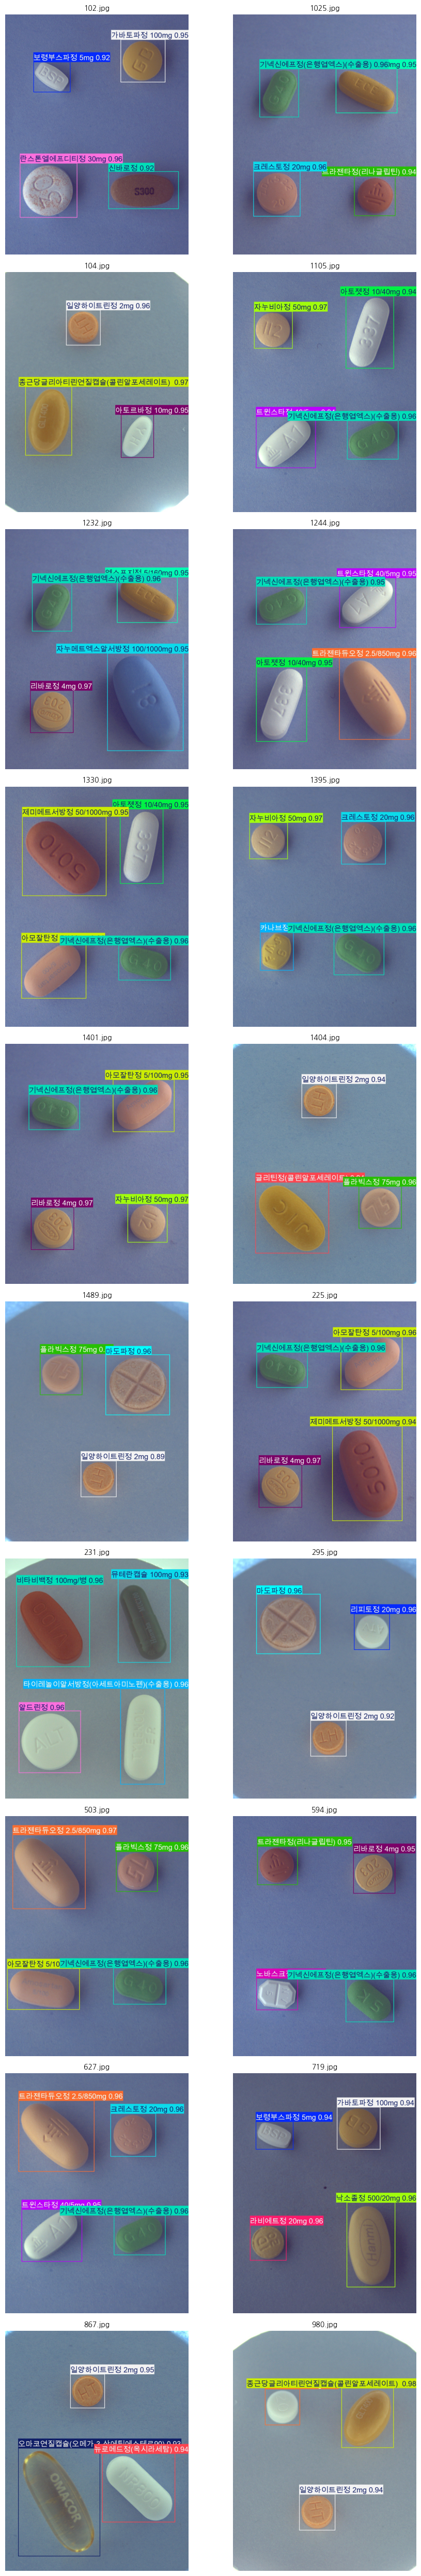

In [ ]:
def visualize_predictions(predict_dir, num_samples=20, cols=4):
    if not os.path.exists(predict_dir):
        raise FileNotFoundError(f"예측 디렉토리 '{predict_dir}'가 존재하지 않습니다.")

    # 이미지 목록 필터링
    image_files = [f for f in os.listdir(predict_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if len(image_files) == 0:
        raise ValueError("해당 디렉토리에 시각화할 이미지 파일이 없습니다.")

    # 무작위 샘플 선택 (정렬 추가)
    sample_images = sorted(random.sample(image_files, min(num_samples, len(image_files))))

    rows = (len(sample_images) + cols - 1) // cols
    plt.figure(figsize=(cols * 5, rows * 5), dpi=100)

    for i, filename in enumerate(sample_images):
        img_path = os.path.join(predict_dir, filename)
        try:
            img = Image.open(img_path).convert("RGB")
            img.thumbnail((800, 800))
        except Exception as e:
            print(f"이미지 로딩 오류: {filename} → {e}")
            continue

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(filename, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions("/content/drive/MyDrive/codeit_level1_project/yolo11_0602/test_result", num_samples=20, cols=2)

## **7. 제출 csv 파일 생성**

- 모델의 예측 결과를 기반으로 Kaggle 제출 포맷에 맞는 csv 파일을 생성한다.
- test_images 폴더의 이미지 파일명은 중간중간 누락된 번호가 많기 때문에, 단순한 순번(1, 2, 3...)이 아닌, 파일명에서 추출한 실제 숫자 ID를 그대로 사용해야 한다.
- 클래스 번호는 제출 시 반드시 주어진 category_id와 정확히 매핑해야 평가가 올바르게 이루어진다.

In [ ]:
# 클래스 매핑 로드
with open("/content/drive/MyDrive/codeit_level1_project/data/classid_to_categoryid.json", "r") as f:
    class_to_category = json.load(f)
    class_to_category = {int(k): v for k, v in class_to_category.items()}

# 결과 파싱 및 저장
rows = []
annotation_id = 1

for result in results:
    # image_id: 원본 이미지 경로에서 파일명 숫자 추출
    filename = result.path.split("/")[-1]
    image_id = int(filename.split(".")[0])

    boxes = result.boxes
    if boxes is None or boxes.xywh is None:
        continue

    for i in range(len(boxes.xywh)):
        x, y, w, h = boxes.xywh[i].tolist()
        score = float(boxes.conf[i])
        cls = int(boxes.cls[i])
        category_id = class_to_category.get(cls, -1)

        if category_id == -1:
            continue  # 매핑 실패한 클래스는 제외

        # COCO 포맷: x_min, y_min, width, height
        xmin = round(x - w / 2)
        ymin = round(y - h / 2)
        bbox_w = round(w)
        bbox_h = round(h)

        rows.append([
            annotation_id,
            image_id,
            category_id,
            xmin,
            ymin,
            bbox_w,
            bbox_h,
            round(score, 2)
        ])
        annotation_id += 1

# CSV 저장
df = pd.DataFrame(rows, columns=[
    "annotation_id", "image_id", "category_id",
    "bbox_x", "bbox_y", "bbox_w", "bbox_h", "score"
])
csv_path = "/content/drive/MyDrive/codeit_level1_project/yolo11_0602/submission_yolo11_0602.csv"
df.to_csv(csv_path, index=False)
print(f"제출 파일 저장됨: {csv_path} (총 {len(df)}개 bounding box 포함)")

제출 파일 저장됨: /content/drive/MyDrive/codeit_level1_project/yolo11_0602/submission_yolo11_0602.csv (총 3237개 bounding box 포함)
